In [1]:
import BioSimSpace as BSS
import sys
import networkx as nx
import pickle
import itertools as it

import warnings
warnings.filterwarnings(action='once')


if '/home/anna/Documents/cinnabar' not in sys.path:
    sys.path.insert(1, '/home/anna/Documents/cinnabar')
import cinnabar

print(cinnabar.__file__)


try:
    import pipeline
except:
    print("adding code to the pythonpath...")
    code = '/home/anna/Documents/code/python'
    if code not in sys.path:
        sys.path.insert(1, code)
    import pipeline

from pipeline import *
from pipeline.analysis import *


Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest 


Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.

/home/anna/Documents/cinnabar/cinnabar/__init__.py
adding code to the pythonpath...


In [3]:
res_dir = "/home/anna/Documents/benchmark/tyk2_benchmark/outputs"
res_obj = analysis_engines(res_dir, exp_file="/home/anna/Documents/benchmark/inputs/experimental/tyk2.yml")
res_obj.compute()
print("done")

no network file, will use all perturbations found in results files from the results dir.
no results output folder provided, writing all output to the 'results_directory'.
lig_jmc23~lig_jmc28 or lig_jmc28~lig_jmc23 does not exist in the results for ['lig_jmc23~lig_jmc28', 'lig_jmc28~lig_ejm46', 'lig_ejm46~lig_jmc23']. This cycle is not included.
lig_jmc27~lig_jmc28 or lig_jmc28~lig_jmc27 does not exist in the results for ['lig_jmc27~lig_jmc28', 'lig_jmc28~lig_ejm46', 'lig_ejm46~lig_jmc27']. This cycle is not included.
lig_jmc30~lig_jmc28 or lig_jmc28~lig_jmc30 does not exist in the results for ['lig_jmc30~lig_jmc28', 'lig_jmc28~lig_ejm46', 'lig_ejm46~lig_jmc30']. This cycle is not included.
lig_jmc27~lig_jmc30 or lig_jmc30~lig_jmc27 does not exist in the results for ['lig_jmc27~lig_jmc30', 'lig_jmc30~lig_ejm46', 'lig_ejm46~lig_jmc27']. This cycle is not included.
lig_jmc23~lig_jmc30 or lig_jmc30~lig_jmc23 does not exist in the results for ['lig_jmc23~lig_jmc30', 'lig_jmc30~lig_ejm46', '

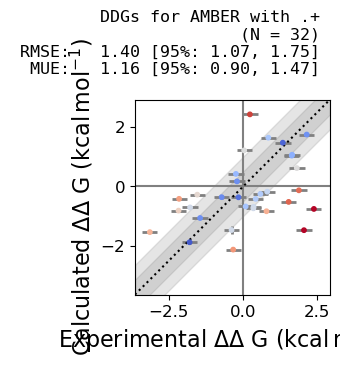

In [11]:
res_obj.plot_scatter_pert(engine="AMBER", use_cinnabar=True)

In [3]:
plot_ana = plotting_engines(res_obj, res_folder="/home/anna/Documents/code/test/results")

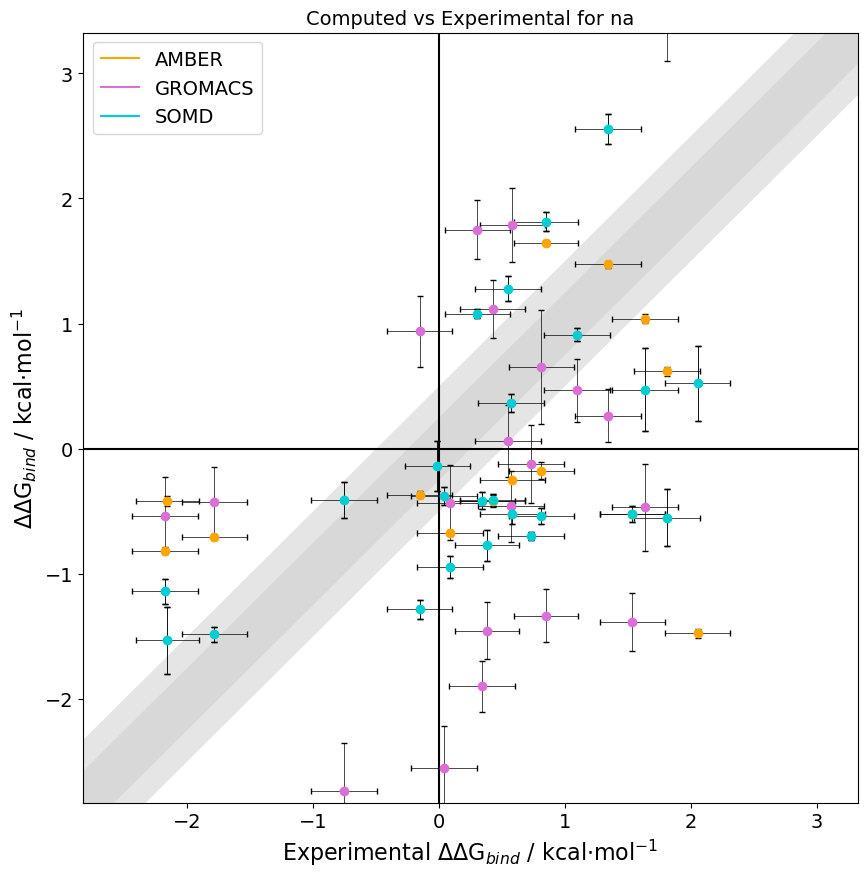

In [7]:
plot_ana.scatter(pert_val="pert")

In [8]:
! ls /home/anna/Documents/code/test/results

/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/pty.py:85: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f54583b03a0>
  pid, fd = os.forkpty()
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/pty.py:85: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f55bd9bf640>
  pid, fd = os.forkpty()
analysis_network.png
computed_perturbations_average_test_AMBER.csv
computed_perturbations_average_test_GROMACS.csv
computed_perturbations_average_test_SOMD.csv
exp_data_tyk2.dat
fep_pert_results_table__AMBER.csv
fep_pert_results_table__GROMACS.csv
fep_pert_results_table__SOMD.csv
fep_val_results_table__AMBER.csv
fep_val_results_table__GROMACS.csv
fep_val_results_table__SOMD.csv
fep_vs_exp_barplot_val__GROMACS.png


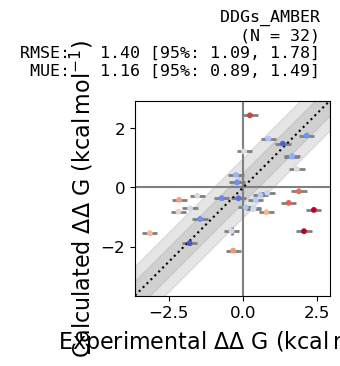

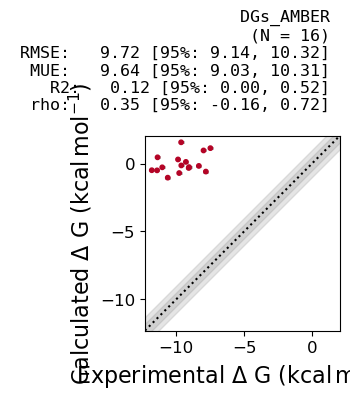

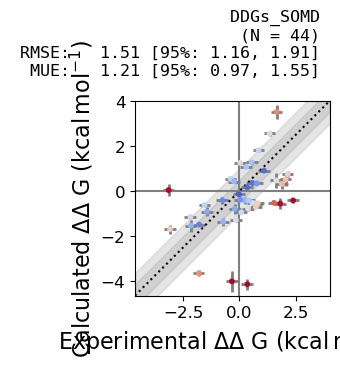

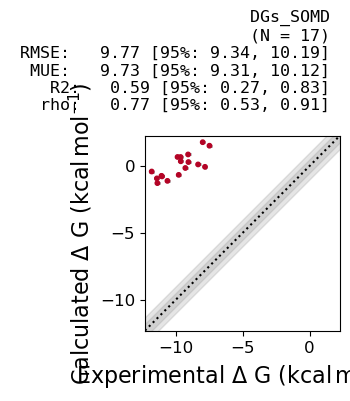

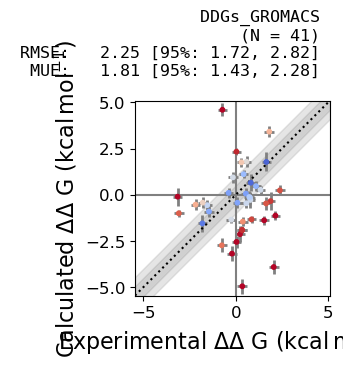

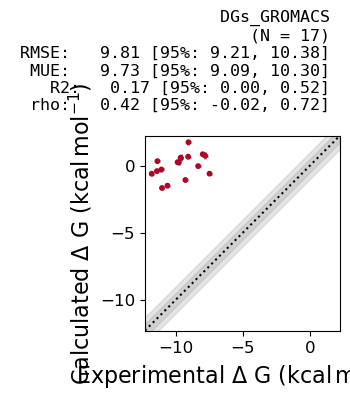

In [14]:
from cinnabar import wrangle,plotting


for eng in res_obj.engines:

    network = wrangle.FEMap(f"/home/anna/Documents/benchmark/tyk2_benchmark/outputs/cinnabar_{eng}.csv")
    # network.graph is the graph object
    # plot the perturbations
    plotting.plot_DDGs(network.graph, filename=f"DDGs_{eng}.png", title=f"DDGs_{eng}")
    #plot the ligands
    plotting.plot_DGs(network.graph, filename=f"DGs_{eng}.png", title=f"DGs_{eng}")

In [8]:
network.generate_graph_from_results()
network.n_edges

32

In [ ]:
    plotting.plot_DDGs(network.graph, filename=f"{res_folder}/DDGs_{file_ext_out}_{eng}.png", title=f"DDGs_{protein}_{file_ext_out}_{eng}")
    #plot the ligands
    plotting.plot_DGs(network.graph, filename=f"{res_folder}/DGs_{file_ext_out}_{eng}.png", title=f"DGs_{protein}_{file_ext_out}_{eng}")

In [ ]:
# for prot, net in it.product(["tyk2","p38","mcl1"],["rbfenn","lomap"]):

#     results_files = ["/home/anna/Documents/code/test/final_summary_SOMD_MBAR_alchemlyb_benchmark.csv"]
#     engine = "SOMD"
#     output_folder = "/home/anna/Documents/code/test"
#     net_file = f"/home/anna/Documents/benchmark/{prot}_benchmark/execution_model/network_{net}.dat"
#     weight_file = f"/home/anna/Documents/benchmark/{prot}_benchmark/execution_model/network_{net}_scores.dat"

#     perturbations, ligands, mod_results_files = get_info_network(results_files, net_file, extra_options={"engine":engine})

#     graph_x = graph(ligands, perturbations)
#     graph_x.add_weight(weight_file)
#     # graph_x.draw_graph()
#     avg_weighted = graph_x.get_average_weighted_simple_paths()
#     print(f"{prot} {net} is {avg_weighted}")

#     with open(f"{output_folder}/graph_{prot}_{net}.pickle", 'wb') as handle:
#         pickle.dump(graph_x.graph, handle)

# # cycles = graph.cycle_closures()
# # print(cycles)

# # nx.get_edge_attributes(graph_x.graph, "weight")

# # print(len(perturbations))


# # with open(f"{output_folder}/graph_tyk2_rbfenn.pickle", "rb") as file:
# #     graph_t = pickle.load(file)
# # print(type(graph_t))
# # nx.get_edge_attributes(graph_t, "weight")

In [ ]:
# import MDAnalysis
# from MDAnalysis.tests.datafiles import PSF,DCD,CRD
# u = MDAnalysis.Universe(PSF,DCD)
# ref = MDAnalysis.Universe(PSF,DCD)     # reference closed AdK (1AKE) (with the default ref_frame=0)
# #ref = MDAnalysis.Universe(PSF,CRD)    # reference open AdK (4AKE)

# import MDAnalysis.analysis.rms

# R = MDAnalysis.analysis.rms.RMSD(u, ref,
#            select="backbone",             # superimpose on whole backbone of the whole protein
#            groupselections=["backbone and (resid 1-29 or resid 60-121 or resid 160-214)",   # CORE
#                             "backbone and resid 122-159",                                   # LID
#                             "backbone and resid 30-59"])                                    # NMP
# R.run()

# import matplotlib.pyplot as plt
# rmsd = R.rmsd.T   # transpose makes it easier for plotting
# time = rmsd[1]
# fig = plt.figure(figsize=(4,4))
# ax = fig.add_subplot(111)
# ax.plot(time, rmsd[2], 'k-',  label="all")
# ax.plot(time, rmsd[3], 'k--', label="CORE")
# ax.plot(time, rmsd[4], 'r--', label="LID")
# ax.plot(time, rmsd[5], 'b--', label="NMP")
# ax.legend(loc="best")
# ax.set_xlabel("time (ps)")
# ax.set_ylabel(r"RMSD ($\AA$)")
# fig.savefig("rmsd_all_CORE_LID_NMP_ref1AKE.pdf")

In [ ]:
files